<a href="https://colab.research.google.com/github/chuancao26/islp/blob/main/LabNonLinearApproach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 2.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=058b5f0a0be97f470232176d924c76ed56daa0c931ac3f09cb296e551eb0ee1e
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


imports iniciales

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (summarize,
                        poly,
                        ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

New imports

In [3]:
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)

# Polynomial regression and Step Functions

In [4]:
# cargando la data
df = load_data('Wage')
y = df["wage"]
age = df["age"]


In [5]:
# vamos a fittear una 4-d polinomial regression.
poly_age = MS([poly("age", degree=4)]).fit(df)
M = sm.OLS(y, poly_age.transform(df)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [6]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({"age": age_grid})

Generador de graficos con una basis transformation

In [7]:
def plot_wage_fit(age_df,
                  basis,
                  title):
  X = basis.transform(df)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha=0.05)
  fig, ax = plt.subplots(figsize=(8,8))
  ax.scatter(age, y,
             facecolor="gray",
             alpha=.5)
  for val, ls in zip([preds.predicted_mean, bands[:, 0], bands[:, 1]],
                      ["b", "r--", "r--"]):
    ax.plot(age_df.values, val, ls, linewidth=2)
  ax.set_title(title, fontsize=20)
  ax.set_xlabel("Age", fontsize=20)
  ax.set_ylabel("Wage", fontsize=20)
  return ax

<Axes: title={'center': 'Degree-4 polynomial'}, xlabel='Age', ylabel='Wage'>

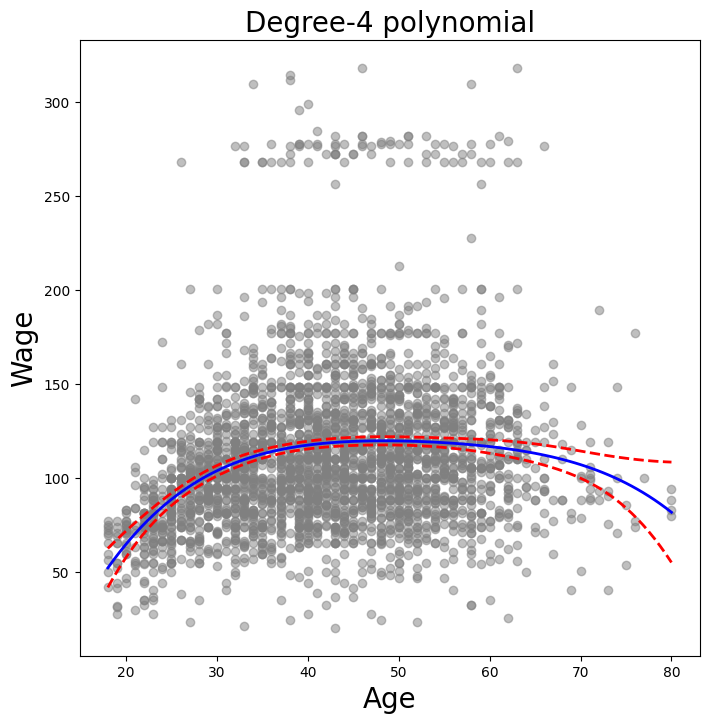

In [8]:
plot_wage_fit(age_df,
              poly_age,
              "Degree-4 polynomial")

In [9]:
 # veamos un grafico con diferentes degrees polynomial
models = [MS([poly("age", degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(df) for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [10]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Ahora veamos el caso de una regresion Logistica

In [11]:
X = poly_age.transform(df)
high_earn = df["high_earn"] = y < 250

glm = sm.GLM(high_earn,
             X,
               family=sm.families.Binomial())
B = glm.fit()
summarize(B)


,coef,std err,z,P>|z|
intercept,4.3012,0.345,12.457,0.000
"poly(age, degree=4)[0]",-71.9642,26.133,-2.754,0.006
"poly(age, degree=4)[1]",85.7729,35.929,2.387,0.017
"poly(age, degree=4)[2]",-34.1626,19.697,-1.734,0.083
"poly(age, degree=4)[3]",47.4008,24.105,1.966,0.049


In [12]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha=0.05)

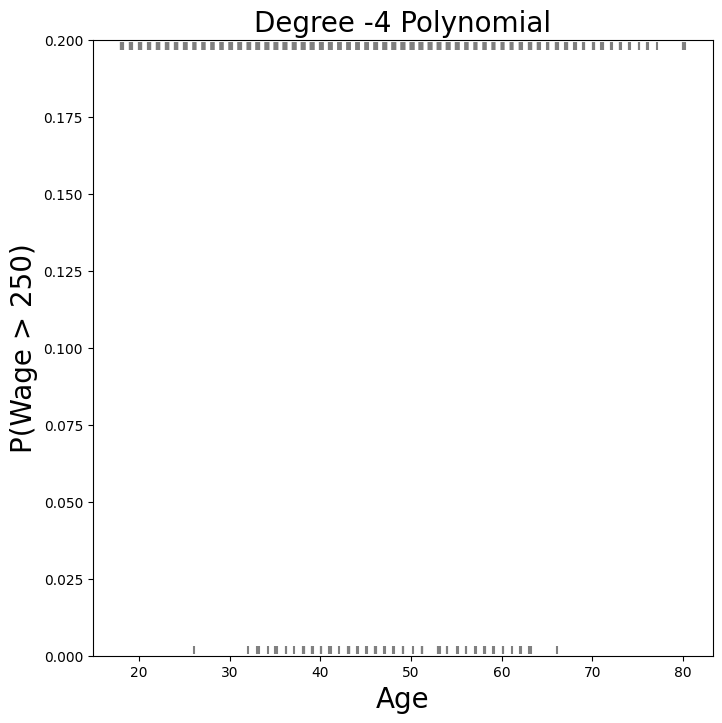

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
rng = np.random.default_rng(0)
ax.scatter(age +
           0.2 * rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc='gray',
           marker='|')
for val, ls in zip([preds.predicted_mean ,
                    bands[:,0],
                    bands[:,1]],
                     ['b','r--','r--']):
  ax.plot(age_df.values, val, ls, linewidth=2)
ax.set_title('Degree -4 Polynomial', fontsize=20)
ax.set_xlabel('Age', fontsize=20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage > 250)', fontsize=20);

## Step Function (faltan graficos)

Vamos a ver el caso de pd.qcut para categorizar la variable age

In [14]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


# Splines

In [15]:
bs_ = BSpline(internal_knots=[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

Tambien podemos hacerlo usando el MS

In [16]:
bs_age = MS([bs("age", internal_knots=[25,40,60],
                name="bs(age)")]).fit(df)
Xbs = bs_age.transform(df)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Veamos cuando los knots son automaticos

In [17]:
BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

 Veamos el caso con 0 degres en el spline


In [18]:
bs_age0 = MS([bs("age", df=3, degree=0)]).fit(df)
Xbs0 = bs_age0.transform(df)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


# Natural Splines

In [19]:
ns_age = MS([ns("age", df=5)]).fit(df)
M_ns = sm.OLS(y, ns_age.transform(df)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


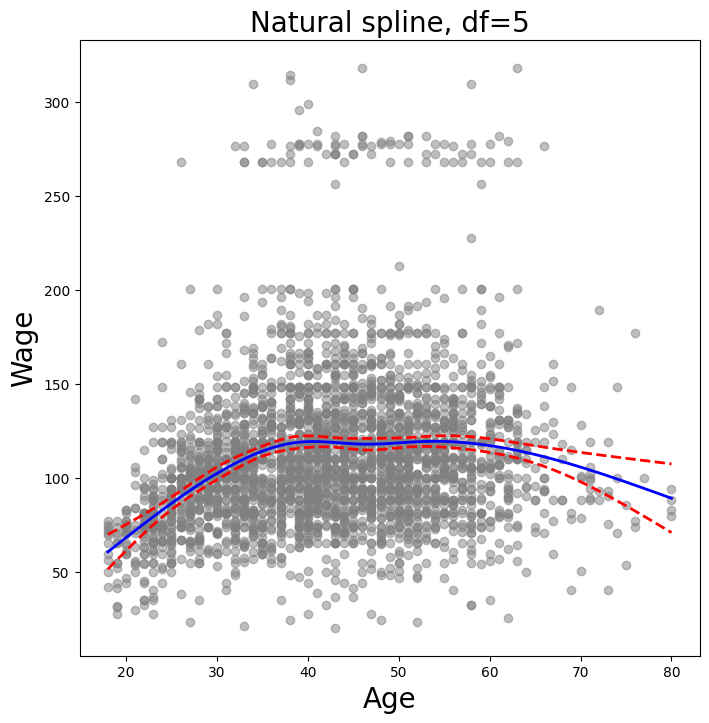

In [20]:
plot_wage_fit(age_df,
ns_age,
'Natural spline, df=5');

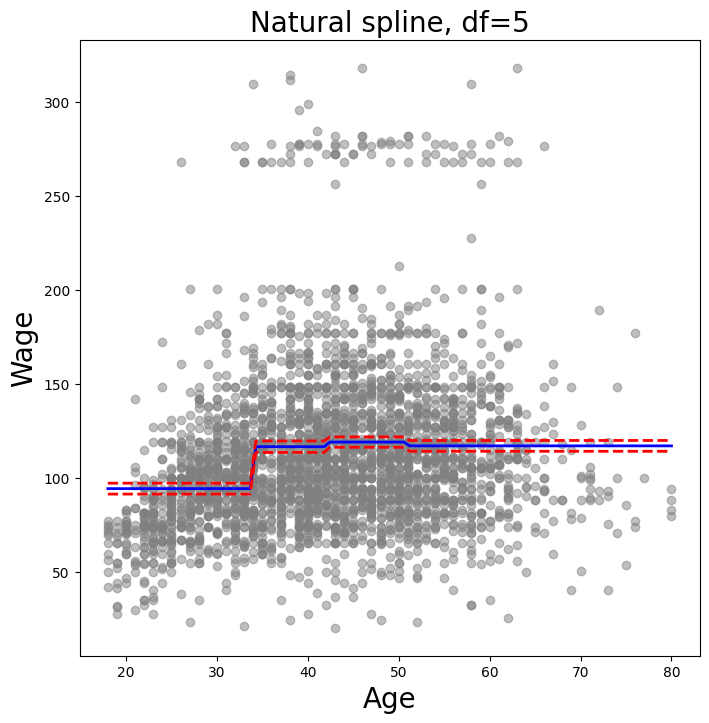

In [21]:
plot_wage_fit(age_df,
bs_age0,
'Natural spline, df=5');

# GAM

In [22]:
X_age = np.asarray(age).reshape((-1,1))
gam = LinearGAM(s_gam(0, lam=0.6))
gam.fit(X_age, y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

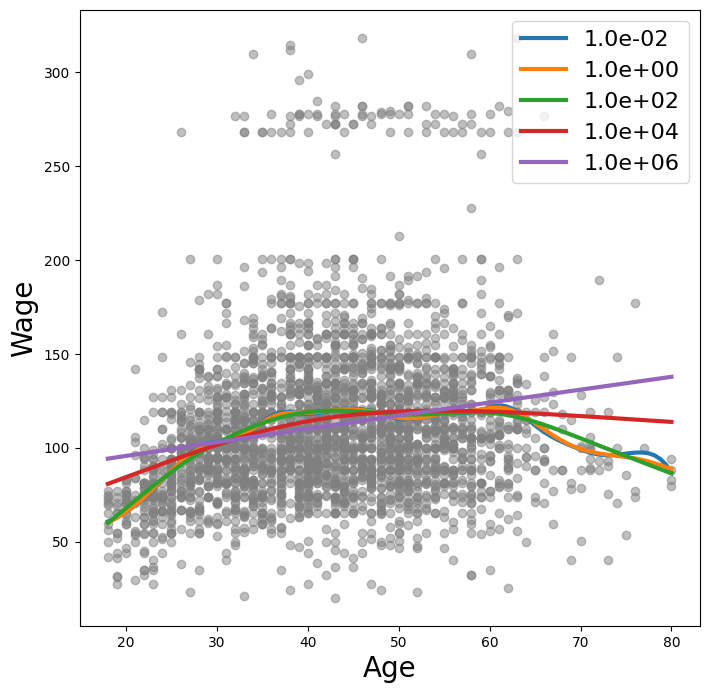

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(age, y,
           facecolor="gray",
           alpha=.5)
for lam in np.logspace(-2, 6, 5):
  gam = LinearGAM(s_gam(0, lam=lam)).fit(X_age, y)
  ax.plot(age_grid,
          gam.predict(age_grid),
          label='{:.1e}'.format(lam),
          linewidth=3)
ax.set_xlabel("Age", fontsize=20)
ax.set_ylabel("Wage", fontsize=20)
ax.legend(fontsize=16)
plt.show()

In [29]:
age_grid

array([18.        , 18.62626263, 19.25252525, 19.87878788, 20.50505051,
       21.13131313, 21.75757576, 22.38383838, 23.01010101, 23.63636364,
       24.26262626, 24.88888889, 25.51515152, 26.14141414, 26.76767677,
       27.39393939, 28.02020202, 28.64646465, 29.27272727, 29.8989899 ,
       30.52525253, 31.15151515, 31.77777778, 32.4040404 , 33.03030303,
       33.65656566, 34.28282828, 34.90909091, 35.53535354, 36.16161616,
       36.78787879, 37.41414141, 38.04040404, 38.66666667, 39.29292929,
       39.91919192, 40.54545455, 41.17171717, 41.7979798 , 42.42424242,
       43.05050505, 43.67676768, 44.3030303 , 44.92929293, 45.55555556,
       46.18181818, 46.80808081, 47.43434343, 48.06060606, 48.68686869,
       49.31313131, 49.93939394, 50.56565657, 51.19191919, 51.81818182,
       52.44444444, 53.07070707, 53.6969697 , 54.32323232, 54.94949495,
       55.57575758, 56.2020202 , 56.82828283, 57.45454545, 58.08080808,
       58.70707071, 59.33333333, 59.95959596, 60.58585859, 61.21